## Goal: Create a fully connected feed foward neural network to predict Spectra Anisotropy Matrix Sum (SAMS) from the factor dictionary

In [24]:
import os
import sys
import json

sys.path.append(os.path.abspath(".."))
import helpers  # Import the helpers module from the parent directory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import importlib
importlib.reload(helpers) 

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.reset_option("display.max_colwidth")

# Standardizing Plots
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['legend.fancybox'] = True
plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

### Factor Dictionary Paths

In [25]:
#Read in file and turn it into a dataframe
test_for_big_dataset = "../transformed_data/test_for_big_dataset/factor_df_6_7_2025"

#### Generate Factor and Spectra DF 

In [26]:
normalization_orders = [7] #Specifys the normalization factors for DM QM and S

factor_df, spectra_df = helpers.generate_factor_sam_df(test_for_big_dataset, mat_props = True, dipole = True, quadrupole = True, steinhart=True, normalization_orders=normalization_orders, ox = False, spectra = True)

# Display the DataFrame
print(factor_df.head())
print(factor_df.shape[0])


           chemical_formula cif_name central_atom  space_group_number  \
material                                                                
mp-1518805       NdEuHfCrO6  unknown           Cr                 216   
mp-2218121       MgCr(WO4)2  unknown           Cr                   1   
mp-755220        Li3CrNi3O8  unknown           Cr                  12   
mp-1183696           CrCuO3  unknown           Cr                 221   
mp-1183712           CrGeO3  unknown           Cr                 221   

            average_bond_length  bond_length_std  average_bond_angle  \
material                                                               
mp-1518805                    0                0                   0   
mp-2218121                    0                0                   0   
mp-755220                     0                0                   0   
mp-1183696                    0                0                   0   
mp-1183712                    0                0        

Drop chemical info

In [27]:
factor_df = factor_df.drop(columns = ["average_bond_length", "bond_length_std", "average_bond_angle", "bond_angle_std", "number_of_unique_ligands"])

Clean and align data frames 

In [28]:
factor_df, spectra_df, dropped_factor_df = helpers.align_dataframes(factor_df, spectra_df)

Dropped duplicate indices:
Empty DataFrame
Columns: [chemical_formula, cif_name, central_atom, space_group_number, average_electronegativity, std_electronegativity, band_gap, density, oxidation_states, dam_1/^7_0, dam_1/^7_1, dam_1/^7_2, dam_1/^7_3, dam_1/^7_4, dam_1/^7_5, dam_1/^7_6, dam_1/^7_7, dam_1/^7_8, dams_1/r^7, qam_1/^7_0, qam_1/^7_1, qam_1/^7_2, qam_1/^7_3, qam_1/^7_4, qam_1/^7_5, qam_1/^7_6, qam_1/^7_7, qam_1/^7_8, qams_1/r^7, steinhart_vector_0, steinhart_vector_sum]
Index: []

[0 rows x 31 columns]

Dropped due to NaN entries:
Empty DataFrame
Columns: [chemical_formula, cif_name, central_atom, space_group_number, average_electronegativity, std_electronegativity, band_gap, density, oxidation_states, dam_1/^7_0, dam_1/^7_1, dam_1/^7_2, dam_1/^7_3, dam_1/^7_4, dam_1/^7_5, dam_1/^7_6, dam_1/^7_7, dam_1/^7_8, dams_1/r^7, qam_1/^7_0, qam_1/^7_1, qam_1/^7_2, qam_1/^7_3, qam_1/^7_4, qam_1/^7_5, qam_1/^7_6, qam_1/^7_7, qam_1/^7_8, qams_1/r^7, steinhart_vector_0, steinhart_vector_su

Compute normed spacegroup number

In [29]:
factor_df = helpers.compute_normed_spacegroup_number(factor_df)

Sum anisotropy matrix elements

In [30]:
spectra_df = helpers.compute_off_diagonal_sum(spectra_df, normalize=True)

Compute the Aniso DM and QM sum for each normalization

In [31]:
# Create a dictionary to hold the new calculated columns
aniso_qm_dm_sum = {}

for n in normalization_orders:
    for m in normalization_orders:
        aniso_qm_dm_sum[f"dams_1/r^{m}_qams_1/r^{n}"] = factor_df[f"dams_1/r^{m}"] + factor_df[f"qams_1/r^{n}"]

# Convert the dictionary to a DataFrame
aniso_qm_dm_sum_df = pd.DataFrame(aniso_qm_dm_sum)

# Efficiently combine with the original DataFrame
factor_df = pd.concat([factor_df, aniso_qm_dm_sum_df], axis=1)


Check the final data frames

In [32]:
print("Factor Data Frame")
print(factor_df.head(5))
print(factor_df.tail(5))

print("Spectra Data Frame")
print(spectra_df.head(5))
print(spectra_df.tail(5))

print("Data Frame Shape")
print(factor_df.shape[0])
print(spectra_df.shape[0])

Factor Data Frame
           chemical_formula cif_name central_atom  space_group_number  \
material                                                                
mp-1024044          Mg3CrO4  unknown           Cr                 221   
mp-1030818        NaMg6CrO8  unknown           Cr                 123   
mp-1030883        Mg6CrSiO8  unknown           Cr                 123   
mp-1031027        LiMg6CrO8  unknown           Cr                 123   
mp-1031245         KMg6CrO8  unknown           Cr                 123   

            average_electronegativity  std_electronegativity  band_gap  \
material                                                                 
mp-1024044                   2.415827               1.032000    0.0000   
mp-1030818                   2.374282               1.075373    2.1237   
mp-1030883                   2.429485               1.023459    2.0172   
mp-1031027                   2.373261               1.070004    2.5121   
mp-1031245                

## Import Dependencies 

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## Prepare and visualize the data

In [34]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # All GPUs (if used)

    # Force deterministic behavior (reproducible at cost of speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Select input features
columns_to_use = [
    "dams_1/r^7_qams_1/r^7", "dams_1/r^7", "qams_1/r^7",
    "dam_1/^7_1", "dam_1/^7_2", "dam_1/^7_5",
    "qam_1/^7_1", "qam_1/^7_2", "qam_1/^7_5",
    "band_gap", "density", "average_electronegativity", "normed_space_group_number"
]

X = factor_df[columns_to_use]
y = spectra_df["sams"]

# Split data (with fixed random seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Visualize the training and testing target data

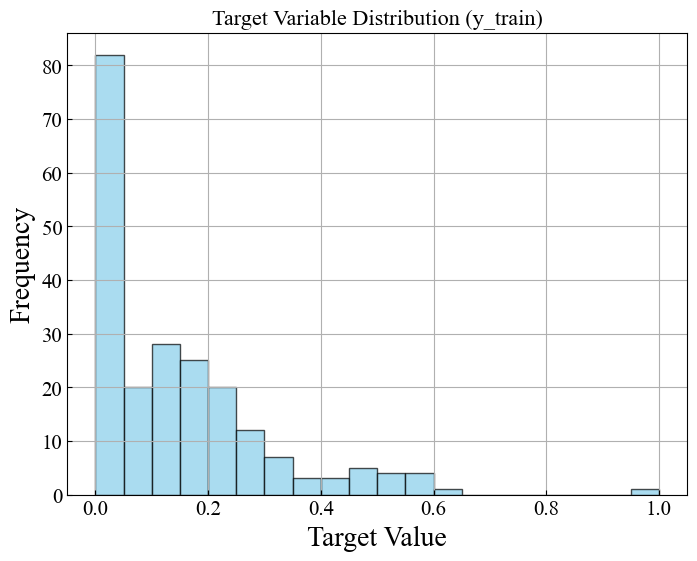

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Target Variable Distribution (y_train)", fontsize=16)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


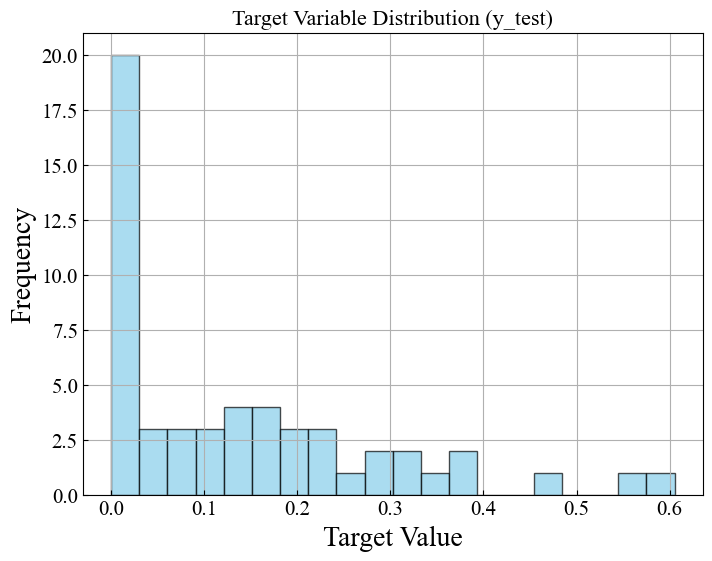

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Target Variable Distribution (y_test)", fontsize=16)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Format the data

In [37]:
# Select batch size
batch_size = 64

# Split
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Scale X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sub)
X_val_scaled = scaler_X.transform(X_val)

# Scale y
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_sub.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

print(f"X_train shape: {X_train_scaled.shape}, y_train shape: {y_train_scaled.shape}")
print(f"X_val shape: {X_val_scaled.shape}, y_val shape: {y_val_scaled.shape}")

# To tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)


train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

input_dim = X_train_tensor.shape[1]

X_train shape: (172, 13), y_train shape: (172, 1)
X_val shape: (43, 13), y_val shape: (43, 1)


## Choose the model

In [38]:
from my_models import ZeroAwareL1Loss, SAMSNetLarge, SAMSNetSmall, SAMSNetCrO 

## Run the model

Define hyper parameters 

In [ ]:
model = SAMSNetSmall(input_dim=input_dim)
loss_fn = ZeroAwareL1Loss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 50

In [45]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_fn=nn.MSELoss(),
    optimizer_class=optim.Adam,
    lr=1e-3,
    num_epochs=50,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": []
    }

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # -------------------
        # Validation phase
        # -------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                y_val_pred = model(X_val_batch)
                val_loss += loss_fn(y_val_pred, y_val_batch).item() * X_val_batch.size(0)

        val_loss /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    return model, history


Train the model

In [46]:
model, history = train_model(
    model,
    train_loader,
    val_loader,
    loss_fn=loss_fn,
    optimizer_class=optimizer.__class__,
    lr=lr,
    num_epochs=num_epochs
)

Epoch 001 | Train Loss: 0.73634 | Val Loss: 0.29894
Epoch 002 | Train Loss: 0.56540 | Val Loss: 0.25210
Epoch 003 | Train Loss: 0.47523 | Val Loss: 0.22453
Epoch 004 | Train Loss: 0.41482 | Val Loss: 0.20563
Epoch 005 | Train Loss: 0.42134 | Val Loss: 0.17866
Epoch 006 | Train Loss: 0.32328 | Val Loss: 0.16333
Epoch 007 | Train Loss: 0.33494 | Val Loss: 0.14838
Epoch 008 | Train Loss: 0.33743 | Val Loss: 0.13420
Epoch 009 | Train Loss: 0.28389 | Val Loss: 0.12188
Epoch 010 | Train Loss: 0.25063 | Val Loss: 0.11347
Epoch 011 | Train Loss: 0.24956 | Val Loss: 0.10506
Epoch 012 | Train Loss: 0.23150 | Val Loss: 0.09600
Epoch 013 | Train Loss: 0.20121 | Val Loss: 0.08143
Epoch 014 | Train Loss: 0.21195 | Val Loss: 0.07852
Epoch 015 | Train Loss: 0.18062 | Val Loss: 0.08129
Epoch 016 | Train Loss: 0.20868 | Val Loss: 0.07937
Epoch 017 | Train Loss: 0.19714 | Val Loss: 0.07875
Epoch 018 | Train Loss: 0.19688 | Val Loss: 0.07539
Epoch 019 | Train Loss: 0.20447 | Val Loss: 0.07332
Epoch 020 | 

## Evaluate the Model

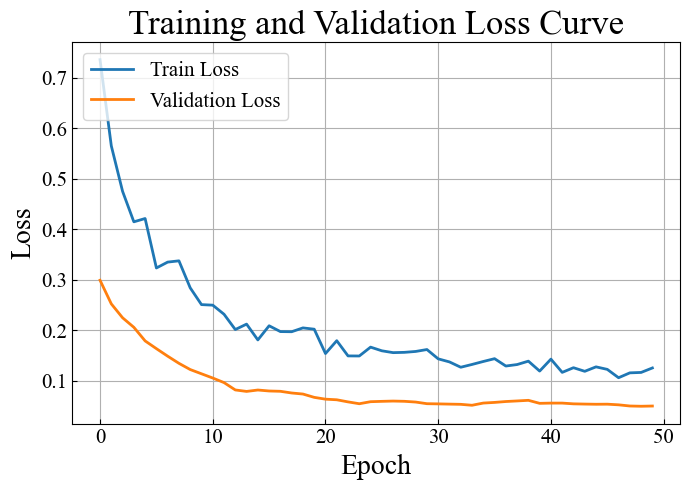

In [47]:
# Plotting the training and validation loss curve
def plot_loss_curve(history):
    plt.figure(figsize=(7, 5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curve(history)

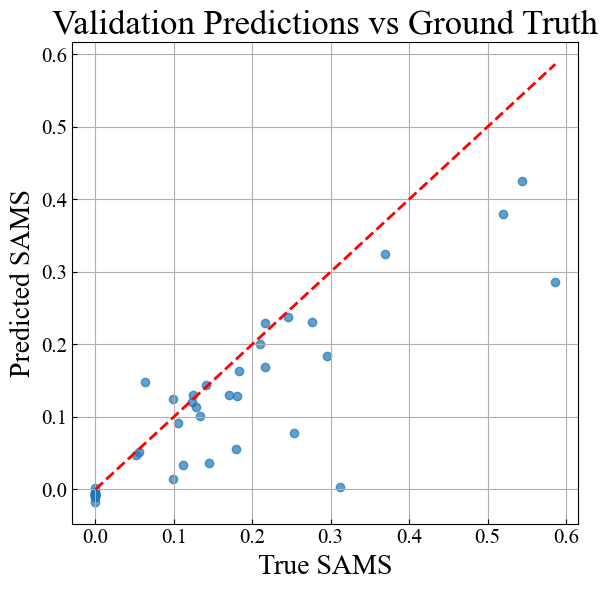

In [48]:
# Function to plot validation predictions
def plot_val_predictions(model, val_loader, scaler_y, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            y_true = y_batch.cpu().numpy()
            y_pred_all.append(y_pred)
            y_true_all.append(y_true)

    # Combine batches
    y_pred_all = np.vstack(y_pred_all)
    y_true_all = np.vstack(y_true_all)

    # Inverse scale
    y_pred_orig = scaler_y.inverse_transform(y_pred_all)
    y_true_orig = scaler_y.inverse_transform(y_true_all)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.7)
    plt.plot([y_true_orig.min(), y_true_orig.max()], [y_true_orig.min(), y_true_orig.max()], 'r--')
    plt.xlabel("True SAMS")
    plt.ylabel("Predicted SAMS")
    plt.title("Validation Predictions vs Ground Truth")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_val_predictions(model, val_loader, scaler_y)